# **Анализ фрейма продукта «Стратегия» на предмет аномалий**

## **Импорт библиотек, загрузка функций, чтение файла**

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import relativedelta

In [2]:
sns.set()

In [3]:
# Функция для исследовательского анализа данных (общая информация, пропуски, дубликаты + анализ данных по столбцам)
def df_eda(df):
  class color:
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    END = '\033[0m'
  
  def tbl_dict_base(df, col):
    tbl_dict = {}
    tbl_dict['valid'] = (~df[col].isnull()).sum()
    tbl_dict['valid_pct'] = tbl_dict['valid']/len(df)
    tbl_dict['missing'] = (df[col].isnull()).sum()
    tbl_dict['missing_pct'] = tbl_dict['missing']/len(df)
    tbl_dict['unique_values'] = df[col].nunique()
    return tbl_dict

  def display_table(tbl_dict, subset1=['missing', 'missing_pct'], \
                    subset2=['valid_pct', 'missing_pct']):
    tbl_det = pd.DataFrame([tbl_dict])
    tbl_det = (
        tbl_det.style.applymap(lambda x: 'color:red' if x > 0 else 'color:green', 
                              subset=subset1)
        .format('{:0.2%}', subset=subset2)
      )
    display(tbl_det)

  pd.set_option('display.max_columns', None)
  print(color.BOLD + 'General information' + color.END)

  display(df.info())
  df_duples = df.copy()
  print('')
  print(color.BOLD + 'Column stats' + color.END)
  print('')

  missing_cols_cnt = 0
  missing_cols_list = []
  id_duples = 0
  
  for col in df.columns:
    if df[col].dtype == 'object':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      try:
        df[col] = df[col].str.replace('ё','е')
        tbl_dict['case_sensitive_dupl'] = (
          df[col].str.lower().duplicated().sum() - df[col].duplicated().sum()
        )
        if tbl_dict['case_sensitive_dupl'] > 0:
          df_duples[col] = df_duples[col].str.lower()
        
        display_table(tbl_dict, ['missing', 'missing_pct', 'case_sensitive_dupl'])
      
      except:
        print('Dtype check needed')
        display_table(tbl_dict)
            
      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)

      if tbl_dict['unique_values'] > 5:
        most_common = df[col].value_counts(normalize=True).reset_index()
        most_common.columns=['Most common', col]
        most_common['Most common'] = (
            most_common['Most common']
            .where(most_common['Most common']
                  .isin(df[col].value_counts(normalize=True).head(5).index), 'other')
        )
        most_common = (
            most_common.groupby('Most common', sort=False)[col]
            .agg('sum').to_frame('')
        )

      else:
        most_common = df[col].value_counts(normalize=True).reset_index()
        most_common.columns=['Most common', '']
        most_common = most_common.set_index('Most common')
      
      display(most_common.style.format('{:0.1%}'))
      print('')

    elif df[col].dtype == 'float' or df[col].dtype == 'int64':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      tbl_dict['zeros'] = len(df[df[col] == 0])
      tbl_dict['negatives'] = len(df[df[col] < 0])
      display_table(tbl_dict)

      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)
      
      if tbl_dict['unique_values'] < 50:
        sns.histplot(df[col], bins=tbl_dict['unique_values'])
      elif tbl_dict['unique_values'] > 100:
        sns.histplot(df[col], bins=50)
      else:
        sns.histplot(df[col], bins=tbl_dict['unique_values']//2)
      plt.show();
      tbl_stats = pd.DataFrame({'':[df[col].mean(), df[col].median(), 
                                   df[col].std(), df[col].min(),
                                   df[col].max(), df[col].quantile(0.01),
                                   df[col].quantile(0.99)]})
      tbl_stats.index = ['mean', 'median', 'std', 'min', 'max', 
                         '1st quantile', '99th quantile']
      display(tbl_stats.style.format('{:.2f}'))
      print('')

    elif df[col].dtype == 'datetime64[ns]':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      display_table(tbl_dict)

      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)

      if tbl_dict['unique_values'] < 50:
        sns.histplot(df[col], bins=tbl_dict['unique_values'])
      elif tbl_dict['unique_values'] > 100:
        sns.histplot(df[col], bins=50)
      else:
        sns.histplot(df[col], bins=tbl_dict['unique_values']//2)
      plt.xticks(rotation=45)
      plt.show();
      display(df[col].apply(['min', 'max', 'mean']).to_frame(''))
      print('')

    elif df[col].dtype == 'bool':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      display_table(tbl_dict)
      display(df[col].value_counts(normalize=True).to_frame('').style.format('{:0.1%}'))
      
      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)
    
    else:
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      print('manual analysis needed')

    if col.lower() == 'id' or col.lower() == 'userid' or col.lower() == 'user_id':
        id_duples = df[col].duplicated().sum()
  
  print(color.BLUE + 'EDA brief' + color.END)
  print('')
  print(f'Rows in dataset: {df.shape[0]}')
  print(f'Columns in dataset: {df.shape[1]}')
  print(f'Number of columns with missing values: {missing_cols_cnt}')
  print('Columns with missing values: ', missing_cols_list)
  print('')

  print(color.BOLD + 'Duplicates in dataset: ' + color.END)
  tbl_dupl = (
      pd.DataFrame({'duples_cnt':[df.duplicated().sum()], 
                    'duples_pct':[df.duplicated().sum()/len(df)],
                    'case_sensitive_duples':[(df_duples.duplicated().sum()-df.duplicated().sum())],
                    'case_sensitive_pct':[(df_duples.duplicated().sum()-df.duplicated().sum())/len(df)], 
                    'id_duples':[id_duples],
                    'id_duples_pct':[id_duples/len(df)]})
      .style.applymap(lambda x: 'color:red' if x > 0 else 'color:green')
      .format('{:.2%}', subset=['duples_pct', 'case_sensitive_pct', 'id_duples_pct'])
  )
  display(tbl_dupl)

In [9]:
try:
    with open('test_frame_V1.json') as f:
      data = json.load(f)
except:
    print('Проверьте путь к файлу')

In [10]:
df = pd.DataFrame(data)

## **Предварительная обработка данных, исследовательский анализ**

In [11]:
df.head()

,Клиент,Дата рождения,Брокерский счет,Услуга,Начало,Окончание
0,User_0,2-3-1989,Broker_account_0,Strategy_0,2020-06-17T12:28:00.000Z,None
1,User_1,15-7-1981,Broker_account_1,Strategy_0,2020-11-27T16:39:12.000Z,2021-02-02T15:11:57.000Z
2,User_10,14-8-1988,Broker_account_10,Strategy_2,2020-12-09T11:59:27.000Z,None
3,User_10,14-8-1988,Broker_account_14023,Strategy_238,2020-09-24T12:54:06.000Z,2021-02-04T16:49:55.000Z
4,User_10,14-8-1988,Broker_account_14024,Strategy_236,2020-11-10T15:52:13.000Z,None


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17271 entries, 0 to 17270
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Клиент           17271 non-null  object
 1   Дата рождения    17271 non-null  object
 2   Брокерский счет  17271 non-null  object
 3   Услуга           17271 non-null  object
 4   Начало           17271 non-null  object
 5   Окончание        4828 non-null   object
dtypes: object(6)
memory usage: 809.7+ KB


In [13]:
# Переведем стобцы с датами (Начало, Окончание, Дата рождения) в формат datetime
df['start_dt'] = pd.to_datetime(df['Начало']).dt.tz_localize(None)
df['end_dt'] = pd.to_datetime(df['Окончание']).dt.tz_localize(None)
df['dob'] = pd.to_datetime(df['Дата рождения'], format='%d-%m-%Y')

Удалим столбцы Дата рождения, Начало и Окончания и переименуем оставшиеся в более удобный для анализа вид (без пробелов, с использованием латиницы и snake case)

In [14]:
df = df.drop(['Дата рождения', 'Начало', 'Окончание'], axis=1)

In [15]:
df.columns

Index(['Клиент', 'Брокерский счет', 'Услуга', 'start_dt', 'end_dt', 'dob'], dtype='object')

In [16]:
df.columns = ['client', 'broker_account', 'strategy', 'start_dt', 'end_dt', 'dob']

General information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17271 entries, 0 to 17270
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client          17271 non-null  object        
 1   broker_account  17271 non-null  object        
 2   strategy        17271 non-null  object        
 3   start_dt        17271 non-null  datetime64[ns]
 4   end_dt          4828 non-null   datetime64[ns]
 5   dob             17271 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 809.7+ KB


None


Column stats

client - dtype: object


,valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
0,17271,100.00%,0,0.00%,10320,0


,
Most common,
User_766,0.3%
User_2111,0.2%
User_10219,0.1%
User_1949,0.1%
User_6293,0.1%
other,99.1%



broker_account - dtype: object


,valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
0,17271,100.00%,0,0.00%,16456,0


,
Most common,
Broker_account_2354,0.2%
Broker_account_11813,0.0%
Broker_account_11814,0.0%
Broker_account_11811,0.0%
Broker_account_7703,0.0%
other,99.7%



strategy - dtype: object


,valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
0,17271,100.00%,0,0.00%,331,0


,
Most common,
Strategy_59,8.7%
Strategy_16,8.2%
Strategy_17,8.1%
Strategy_18,4.2%
Strategy_362,3.7%
other,67.2%



start_dt - dtype: datetime64[ns]


,valid,valid_pct,missing,missing_pct,unique_values
0,17271,100.00%,0,0.00%,16399


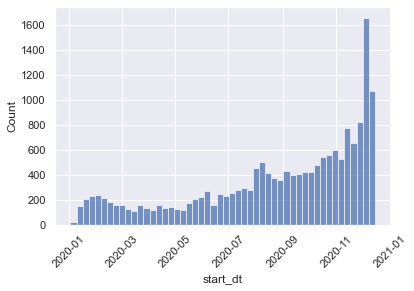

,
min,2020-01-02 13:02:32.000000000
max,2020-12-14 23:49:35.000000000
mean,2020-08-25 22:40:28.245150976



end_dt - dtype: datetime64[ns]


,valid,valid_pct,missing,missing_pct,unique_values
0,4828,27.95%,12443,72.05%,4256


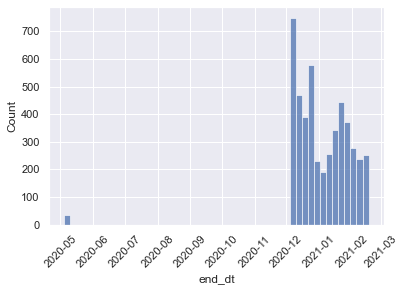

,
min,2020-05-04 14:31:15.000000000
max,2021-02-16 23:36:08.000000000
mean,2021-01-03 05:04:29.465203200



dob - dtype: datetime64[ns]


,valid,valid_pct,missing,missing_pct,unique_values
0,17271,100.00%,0,0.00%,1584


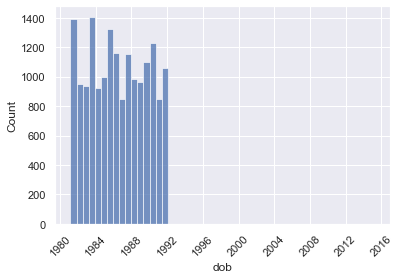

,
min,1981-03-01 00:00:00.000000000
max,2015-04-07 00:00:00.000000000
mean,1986-06-29 06:33:17.290255360



EDA brief

Rows in dataset: 17271
Columns in dataset: 6
Number of columns with missing values: 1
Columns with missing values:  ['end_dt']

Duplicates in dataset: 


,duples_cnt,duples_pct,case_sensitive_duples,case_sensitive_pct,id_duples,id_duples_pct
0,1,0.01%,0,0.00%,0,0.00%


In [17]:
# Применим функцию для предварительного анализа имеющихся данных
df_eda(df)

В датасете содержится информация по 10320 уникальным клиентам. Кол-во уникальных брокерских счетов - 16456, т.е. есть клиенты с несколькими брокерскими счетами. Наиболее часто встречающиеся пользователи - User_766 и User_2111, наиболее часто встречающийся брокерский счет - Broker_account_2354 - целесообразно будет проверить на наличие здесь подозрительной активности. 

Число стратегий - 331. Тройка самых популярных - Strategy_59, Strategy_16 и Strategy_17. Формат первых трех столбцов - object, содержит текстовые переменные. Пропуски отсутствуют.

Дата открытия стратегии (Начало) содержит информацию за период со 2 января 2020 года по 14 декабря 2020 года, т.е. почти за один календарный год. Пропуски отсутствуют. На гистограмме виден всплеск активности по открытию стратегий в конце года - также нужноо проверить, с чем это было связано. 

Дата закрытия стратегии (Окончание) - много пропусков (72%), объясняется тем, что не все стратегии закрыты. Исходим из того, что процент закрытых - 28%, остальные действующие. Замены пропусков не требуется. Данные за период с 4 мая 2020 года по 16 февраля 2021 года (есть смещение по времени по сравнению с периодом открытия стратегий - надо будет сопоставить на общей гистограмме). Гистограмма распределения данных по закрытым стратегиям выглядит аномально: основная часть закрытий приходится на период, начиная с декабря 2020 года - до этого времени практически не было закрытий, если не считать странного "всплеска" в мае 2020 г. (нужно проверить с чем он был связан). В декабре мы наблюдаем резкий всплеск закрытий и далее закрытия стабильно продолжались, но уже не так активно.

Столбец "Дата рождения" также вызывает вопросы: Среди основной части совершеннолетних клиентов у нас явно "затесался" несовершеннолетний (день рождения самого молодого клиента - 7 апреля 2015 г., т.е. на момент начала стратегии ему было от 5 до 6 лет) - это также требует проверки. Пропусков в этом столбце нет. 

Дубликаты: в датасете один полный дубликат.

## **Анализ аномалий**

### **Дубликаты**

In [18]:
df[df.duplicated(keep=False)]

,client,broker_account,strategy,start_dt,end_dt,dob
5031,User_2111,Broker_account_2354,Strategy_22,2020-05-04 14:30:15,2020-05-04 14:31:15,1986-03-14
5032,User_2111,Broker_account_2354,Strategy_22,2020-05-04 14:30:15,2020-05-04 14:31:15,1986-03-14


Полный дубликат по пользователю User_2111 и брокерскому счету 2354. Оставим пока под вопросом (как вариант - кейс для разработчиков, почему присутствует дубликат), но надо еще проверить, не всплывет ли данная записи в связи с другими аномалиями.

### **Возраст клиентов на момент открытия стратегии**

In [19]:
# Функция для расчета возраста клиента на момент начала стратегии
def age_in_years(row):
    rd = relativedelta.relativedelta(row['start_dt'], row['dob'])
    return rd.years

df['age_of_open'] = df.apply(age_in_years, axis=1)

In [20]:
# Проверим, сколько имеется несовершеннолетних клиентов
df.query('age_of_open < 18')

,client,broker_account,strategy,start_dt,end_dt,dob,age_of_open
11306,User_6066,Broker_account_7044,Strategy_59,2020-08-07 16:48:07,NaT,2015-04-07,5


У нас один несовершеннолетний клиент, которому на момент открытия стратегии было 5 лет. Это User_6066. Данную информацию передаем в юридический отдел.

Проверим еще на всякий случай, нет ли клиентов с одним номером, но разными датами рождения.

In [21]:
len(df.groupby('client')['dob'].agg('nunique').to_frame('cnt').query('cnt>1'))

0

### **Аномалии в гистограммах открытия и закрытия стратегий**

In [22]:
# Выделим из времени начала и окончания только дату для удобства визуализации 
df['start_dt_day'] = df['start_dt'].dt.date
df['start_dt_day'] = pd.to_datetime(df['start_dt_day'], format='%Y-%m-%d')
df['end_dt_day'] = df['end_dt'].dt.date
df['end_dt_day'] = pd.to_datetime(df['end_dt_day'], format='%Y-%m-%d')

In [23]:
df.end_dt_day.nunique()

73

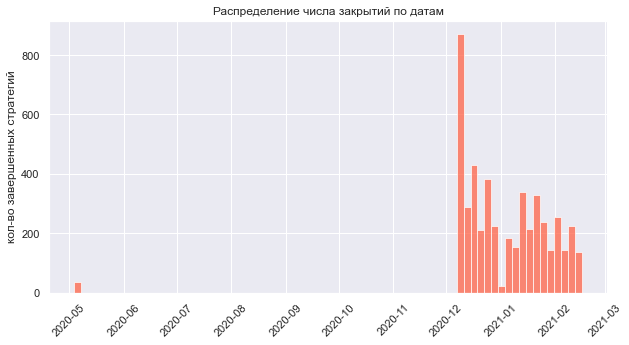

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(df.end_dt_day, bins=73, color='tomato')

plt.title('Распределение числа закрытий по датам')
plt.xlabel('')
plt.ylabel('кол-во завершенных стратегий')
plt.xticks(rotation=45)
plt.show();

In [25]:
df.end_dt_day.min()

Timestamp('2020-05-04 00:00:00')

In [26]:
df.query('end_dt_day == "2020-05-04"').apply('nunique')

client             1
broker_account     1
strategy          33
start_dt           1
end_dt             1
dob                1
age_of_open        1
start_dt_day       1
end_dt_day         1
dtype: int64

In [27]:
df.query('end_dt_day == "2020-05-04"').head()

,client,broker_account,strategy,start_dt,end_dt,dob,age_of_open,start_dt_day,end_dt_day
5008,User_2111,Broker_account_2354,Strategy_1,2020-05-04 14:30:15,2020-05-04 14:31:15,1986-03-14,34,2020-05-04,2020-05-04
5009,User_2111,Broker_account_2354,Strategy_2,2020-05-04 14:30:15,2020-05-04 14:31:15,1986-03-14,34,2020-05-04,2020-05-04
5010,User_2111,Broker_account_2354,Strategy_3,2020-05-04 14:30:15,2020-05-04 14:31:15,1986-03-14,34,2020-05-04,2020-05-04
5011,User_2111,Broker_account_2354,Strategy_4,2020-05-04 14:30:15,2020-05-04 14:31:15,1986-03-14,34,2020-05-04,2020-05-04
5012,User_2111,Broker_account_2354,Strategy_5,2020-05-04 14:30:15,2020-05-04 14:31:15,1986-03-14,34,2020-05-04,2020-05-04


В ситуации со всплеском закрытий в мае 2020 года присутствуют явные аномалии: 4 мая 2020 года один и тот же клиент User_2111 закрыл сразу 33 стратегии, оформленные на один и тот же брокерский счет, причем открытие по всем стратегиям произошло в тот же самый день на минуту раньше. Закрытие всех стратегий было произведено одновременно, секунда в секунду. Открытия всех 33 стратегий также совпадают по времени до секунды. Т.е. новая стратегия открывалась, когда предыдущая еще не была закрыта. Таким образом получается, что все 33 стратегии были оформлены на один и тот же счет одновременно, что, по идее, технически должно быть невозможно. Кстати, это именно тот клиент, который "вылез" у нас в дубликатах.
Направляем этот кейс в отдел к разработчикам для выяснения причин этого бага.

Проверим, есть ли еще клиенты, у которых произошло открытие нескольких стратегий одновременно на один счет.

In [28]:
# Создадим датафрейм с данными, отсорированными по клиентам, брокерским счетам и дате открытия стратегии
# Далее создадим столбец-флаг, где проставим единицы для брокерских счетов, где открытие новой стратегии 
# произошло раньше закрытия предыдущей
df_sorted = df.sort_values(by=['client', 'broker_account', 'start_dt']).reset_index()
df_sorted['flag'] = 0
for i in range(1, len(df_sorted)):
    if df_sorted.loc[i, 'broker_account'] == df_sorted.loc[i-1, 'broker_account'] \
    and df_sorted.loc[i-1, 'end_dt'] > df_sorted.loc[i, 'start_dt']:
        df_sorted.loc[i, 'flag'] = 1
    else:
        df_sorted.loc[i, 'flag'] = 0

In [29]:
df_sorted.query('flag == 1').client.unique()

array(['User_2111'], dtype=object)

Других клиентов, помимо User_2111 с "пересекающимися" стратегиями на одном счете, нет.

Теперь посмотрим поподробнее на аномальный "всплеск" по кол-ву закрытых стратегий в декабре. Одновременно можно посмотреть, как распределялись по датам "открытия" стратегий: возможно, всплеск наблюдался как по закрытиями, так и по открытиям. Для этого визуализируем на одном графике распределение по датам кол-ва уникальных клиентов, запускающих и завершающих стратегии.

In [30]:
clients_close_pd = df.groupby(['end_dt_day'])['client'].agg('nunique').reset_index()
clients_start_pd = df.groupby(['start_dt_day'])['client'].agg('nunique').reset_index()
strats_close_pd = df.groupby(['end_dt_day'])['strategy'].agg('nunique').reset_index()
strats_start_pd = df.groupby(['start_dt_day'])['strategy'].agg('nunique').reset_index()

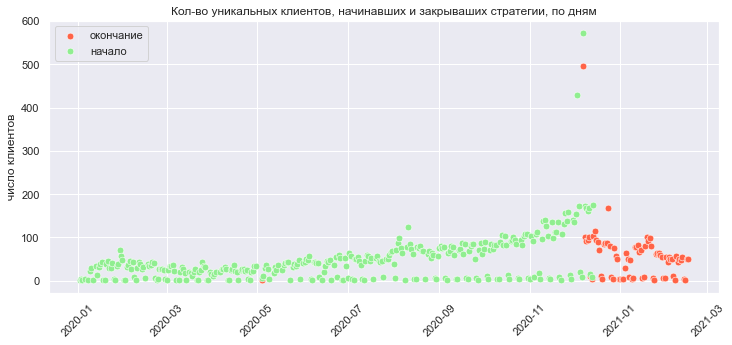

In [31]:
fig, ax = plt.subplots(figsize=(12,5))
sns.scatterplot(x='end_dt_day', y='client', data=clients_close_pd, s=45, color='tomato')
sns.scatterplot(x='start_dt_day', y='client', data=clients_start_pd, s=45, color='lightgreen')

plt.title('Кол-во уникальных клиентов, начинавших и закрываших стратегии, по дням')
plt.xlabel('')
plt.ylabel('число клиентов')
plt.xticks(rotation=45)
plt.legend(['окончание', 'начало'], loc='upper left')
plt.show();

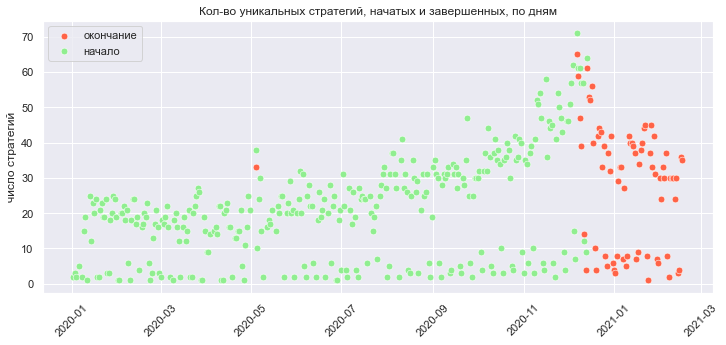

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
sns.scatterplot(x='end_dt_day', y='strategy', data=strats_close_pd, s=45, color='tomato')
sns.scatterplot(x='start_dt_day', y='strategy', data=strats_start_pd, s=45, color='lightgreen')

plt.title('Кол-во уникальных стратегий, начатых и завершенных, по дням')
plt.xlabel('')
plt.ylabel('число стратегий')
plt.xticks(rotation=45)
plt.legend(['окончание', 'начало'], loc='upper left')
plt.show();

In [33]:
# Выведем, сколько уникальных клиентов запустили стратегии в "пиковые" дни
clients_start_pd.sort_values(by='client', ascending=False).head(2)

,start_dt_day,client
316,2020-12-07,572
312,2020-12-03,430


In [34]:
# Выведем, сколько уникальных клиентов закрыли стратегии в пиковый день
clients_close_pd.sort_values(by='client', ascending=False).head(1)

,end_dt_day,client
1,2020-12-07,495


На первом графике, где распределено кол-во уникальных клиентов, открывавших и закрывавших стратегии, по дням, видны три аномальных выброса: два по открытым стратегиям (3 и 7 декабря 2020 г. 430 и 572 клиента соответственно), и один - по закрытым (7 декабря, 495 клиента). В остальные дни года соответствующие показатели были более чем в два с половиной раза ниже. На втором графике (распределение числа открытых и закрытых стратегий по дням) таких аномальных выбросов, в несколько раз превышающих обычные показатели, не просматривается. Судя по всему, всплеск "активности" 7 декабря была связан с какими-то конкретными стратегиями.  

Проверим, насколько равномерно распределялась выходы клиентов по стратегиям. 

In [35]:
# Проверим количественное распределение
df.query('end_dt_day == "2020-12-07"').strategy.value_counts().head(10)

Strategy_258    404
Strategy_239      8
Strategy_236      7
Strategy_234      6
Strategy_59       5
Strategy_16       5
Strategy_148      5
Strategy_362      4
Strategy_238      4
Strategy_17       4
Name: strategy, dtype: int64

In [36]:
# Проверим относительное распределение
df.query('end_dt_day == "2020-12-07"').strategy.value_counts(normalize=True).head(10)

Strategy_258    0.753731
Strategy_239    0.014925
Strategy_236    0.013060
Strategy_234    0.011194
Strategy_59     0.009328
Strategy_16     0.009328
Strategy_148    0.009328
Strategy_362    0.007463
Strategy_238    0.007463
Strategy_17     0.007463
Name: strategy, dtype: float64

Три четверти всех уходов 7 декабря (75,4%) пришлось на одну стратегию (Strategy_258), по остальным стратегиям данные распределились плюс-минус равномерно (1,5% и менее). Получается, что аномалия связана именно с ней, если не брать во внимание 258-ую стратегию, показатели за 7 декабря не выбились бы из общей картины. Такой резкий отток из одной стратегии - повод обратить внимание маркетологов.

Посмотрим, присутствует ли такой же перекос в случае со стратегиями, открытыми 7 декабря.

In [37]:
df.query('start_dt_day == "2020-12-07"').strategy.value_counts().head(10)

Strategy_237    429
Strategy_264     18
Strategy_234     13
Strategy_16      12
Strategy_239     10
Strategy_245      8
Strategy_365      8
Strategy_362      8
Strategy_18       7
Strategy_247      7
Name: strategy, dtype: int64

In [38]:
df.query('start_dt_day == "2020-12-07"').strategy.value_counts(normalize=True).head(10)

Strategy_237    0.680952
Strategy_264    0.028571
Strategy_234    0.020635
Strategy_16     0.019048
Strategy_239    0.015873
Strategy_245    0.012698
Strategy_365    0.012698
Strategy_362    0.012698
Strategy_18     0.011111
Strategy_247    0.011111
Name: strategy, dtype: float64

Со стратегиями, открытыми 7 декабря, ситуации та же: 68% всех открытий приходится на одну стратегию (Strategy_237). 

Стоит еще проверить пересечения между клиентами, открывавшими и закрывавшими стратегии 7 декабря. Возможно, переток из одной стратегии (Strategy_258) в другую (Strategy_237) в этот день совершали одни и те же клиенты.

In [39]:
# Создадим списки клиентов, которые 7 декабря открыли стратегию 237 и которые закрыли стратегию 258
clients_open_list = df.query('start_dt_day == "2020-12-07"').query('strategy == "Strategy_237"').client.unique()
clients_close_list = df.query('end_dt_day == "2020-12-07"').query('strategy == "Strategy_258"').client.unique()

In [40]:
# Зададим функцию для отбора клиентов, которые есть в обоих списках
def intersection_clients(closed, opened):
    intrscted = []
    for i in range(len(closed)):
        if closed[i] in opened:
            intrscted.append(closed[i])
    return intrscted            

In [41]:
# Посмотрим, сколько всего клиентов попали в оба списка одновременно
intersection_list = intersection_clients(clients_close_list, clients_open_list)
len(intersection_list)

399

In [42]:
# Проверим кол-во уникальных данных по закрытой стратегии
(
    df[df['client'].isin(intersection_list)]
    .query('end_dt_day == "2020-12-07"')
    .query('strategy == "Strategy_258"').apply('nunique')
)

client            399
broker_account    400
strategy            1
start_dt          400
end_dt              1
dob               351
age_of_open        12
start_dt_day      160
end_dt_day          1
dtype: int64

In [43]:
# Проверим кол-во уникальных данных по открытой стратегии
(
    df[df['client'].isin(intersection_list)]
    .query('start_dt_day == "2020-12-07"')
    .query('strategy == "Strategy_237"').apply('nunique')
)

client            399
broker_account    401
strategy            1
start_dt            1
end_dt            126
dob               351
age_of_open        11
start_dt_day        1
end_dt_day         52
dtype: int64

In [44]:
(
    df[df['client'].isin(intersection_list)]
    .query('end_dt_day == "2020-12-07"')
    .query('strategy == "Strategy_258"').end_dt.unique()
)

array(['2020-12-07T20:49:09.000000000'], dtype='datetime64[ns]')

In [45]:
(
    df[df['client'].isin(intersection_list)]
    .query('start_dt_day == "2020-12-07"')
    .query('strategy == "Strategy_237"').start_dt.unique()
)

array(['2020-12-07T20:49:10.000000000'], dtype='datetime64[ns]')

Всего получилось 399 пересечений по клиентам. Т.е. почти все, кто "обеспечил" нам аномальный скачок показателей 7 декабря 2020 г., закрыли в этот день стратегию 258 и открыли стратегию 237. 

Еще одна странность заключается в том, что закрытие и открытие стратегии произошло у всех в одно и то же время с точностью до секунды (кол-во уникальных значений end_dt в первом случае и start_dt во втором равно 1), а разница между окончанием и началом стратегии составляла всего 1 секунду, т.е. процесс, судя по всему, был осуществлен автоматически.

По остальным показателям таких аномалий не просматривается: закрытая стратегия 258 открывалась клиентами в разное время и даже в разные дни (кол-во уникальных значений start_dt_day 160). Что касается действий клиентов после открытия стратегии 237, то они тоже разнятся: 126 человек впоследствии закрыли ее (в разные дни), у остальных она пока еще действует. 

Отправляем этот кейс для уточнения ситуации в отдел маркетинга.

In [46]:
df.query('start_dt_day == "2020-12-03"').strategy.value_counts().head()

Strategy_241    258
Strategy_264     24
Strategy_252     22
Strategy_255     14
Strategy_247     12
Name: strategy, dtype: int64

In [47]:
df.query('start_dt_day == "2020-12-03"').strategy.value_counts(normalize=True).head()

Strategy_241    0.557235
Strategy_264    0.051836
Strategy_252    0.047516
Strategy_255    0.030238
Strategy_247    0.025918
Name: strategy, dtype: float64

In [48]:
# Проверим кол-во уникальных данных по открытой стратегии
(
    df.query('start_dt_day == "2020-12-03"')
    .query('strategy == "Strategy_241"').apply('nunique')
)

client            257
broker_account    258
strategy            1
start_dt            1
end_dt             52
dob               231
age_of_open        11
start_dt_day        1
end_dt_day         34
dtype: int64

3 декабря наблюдалась схожая ситуация: всплеск активности связан, в основном с одной стратегией: 258 открытий (55,7%) пришлось на стратегию 241. К ней в этот день присоединилось 257 клиентов с 258 брокерских счетов. Причем начало стратегии у всех клиентов опять-таки совпадает секунда в секунду (число уникальных значений start_dt равно 1). 

Оба кейса по аномальной активности, связанной с единичными стратегиями 3 и 7 декабря, отправляем в отдел маркетинга.

### **Подозрительная активность (аномально часто встречающиеся клиенты, брокерские счета)**

In [50]:
df.client.value_counts().sort_values(ascending=False).head()

User_766      53
User_2111     35
User_10219    22
User_1949     21
User_6293     19
Name: client, dtype: int64

Клиент со счетом 2111 уже вылез у нас выше в связи с подозрительной активностью, теперь проверим клиента со счетом 766, который чаще всего фигурирует у нас в датасете (53 записи).

In [51]:
df.query('client == "User_766"').apply('nunique')

client             1
broker_account    20
strategy          18
start_dt          53
end_dt            45
dob                1
age_of_open        1
start_dt_day      12
end_dt_day         7
dtype: int64

У User_766 20 брокерских счетов, с которых были запущены 18 стратегий. Даты начала стратегий разные, запускались они, судя по всему, по несколько раз (start_dt имеет 53 уникальных значения). Закрывались тоже в разное время. Никаких особых аномалий тут не просматривается, если не считать повышенной активности клиента.

Посмотрим теперь брокерские счета на предмет подозрительной активности.

In [52]:
df.broker_account.value_counts(ascending=False).head()

Broker_account_2354     35
Broker_account_11813     5
Broker_account_11814     5
Broker_account_11811     5
Broker_account_7703      4
Name: broker_account, dtype: int64

In [53]:
df.query('broker_account == "Broker_account_2354"').head(1)

,client,broker_account,strategy,start_dt,end_dt,dob,age_of_open,start_dt_day,end_dt_day
5007,User_2111,Broker_account_2354,Strategy_17,2020-05-04 14:30:15,NaT,1986-03-14,34,2020-05-04,NaT


Клиент со счетом 2354, который чаще всего встречается в датасете (35 раз) - это снова наш "подозрительный" User_2111. 

Проверим теперь клиентов с большим кол-вом брокерских счетов.

In [54]:
df.groupby('client')['broker_account'].agg('nunique').sort_values(ascending=False).head()

client
User_10219    22
User_766      20
User_6831     18
User_4765     18
User_6293     18
Name: broker_account, dtype: int64

In [55]:
df.query('client == "User_10219"').apply('nunique')

client             1
broker_account    22
strategy           1
start_dt          22
end_dt             8
dob                1
age_of_open        1
start_dt_day       5
end_dt_day         1
dtype: int64

In [56]:
df.query('client == "User_10219"').head(5)

,client,broker_account,strategy,start_dt,end_dt,dob,age_of_open,start_dt_day,end_dt_day
636,User_10219,Broker_account_14710,Strategy_254,2020-10-30 01:36:38,NaT,1987-06-13,33,2020-10-30,NaT
637,User_10219,Broker_account_14711,Strategy_254,2020-10-30 01:37:29,NaT,1987-06-13,33,2020-10-30,NaT
638,User_10219,Broker_account_14712,Strategy_254,2020-10-26 10:25:02,2021-01-26 22:49:56,1987-06-13,33,2020-10-26,2021-01-26
639,User_10219,Broker_account_14713,Strategy_254,2020-10-26 10:26:00,2021-01-26 22:55:58,1987-06-13,33,2020-10-26,2021-01-26
640,User_10219,Broker_account_14714,Strategy_254,2020-12-09 15:38:01,2021-01-26 22:49:40,1987-06-13,33,2020-12-09,2021-01-26


А вот здесь можно заподозрить аномальную активность. У User_10219 открыто 22 счета под одну стратегию, причем с некоторых счетов привязка к стратегии осуществляется параллельно. Похоже на то, что деньги разных людей разложены по "разным кошелькам" под одним аккаунтом - отправляем кейс в отдел безопасности.

Проверим, есть ли еще клиенты с большим кол-вом счетов для одной стратегии.

In [57]:
(
    df.groupby('client')[['broker_account', 'strategy']].agg('nunique')
    .reset_index()
    .query('strategy == 1')
    .sort_values(by='broker_account', ascending=False).head(5)
)

,client,broker_account,strategy
242,User_10219,22,1
9235,User_8944,8,1
2198,User_13407,5,1
8025,User_7115,5,1
402,User_10397,3,1


Явно выбивающаяся из общей картины аномалия с большим числом счетов для одной стратегии только одна.

## **Выводы**

**Кейс для юридического отдела**

В датасете обнаружен один несовершеннолетний клиент, которому на момент активности со стратегиями было 5 лет. Это User_6066. Указанная в системе дата рождения - 7 апреля 2015 года. Кейс должен быть изучен юристами, поскольку тут возникает вопрос юридической чистоты сделок.

**Кейс для разработчиков**

4 мая 2020 года в системе зафиксировано что-то похожее на баг: один и тот же клиент User_2111 открыл и закрыл сразу 33 стратегии на один и тот же брокерский счет. Открытия всех 33 стратегий совпадают по времени до секунды. Время закрытия также совпадает до секунды. Вопрос стоит изучить разработчикам, поскольку 33 стратегии были оформлены на один и тот же счет одновременно, что технически должно быть невозможно. 

**Кейс для отдела маркетинга**

7 декабря 2020 г. наблюдался аномальный скачок по кол-ву клиентов, начавших и завершивших стратегии. Как выяснилось, основная «активность» в этот день была связана с двумя стратегиями: 399 клиентов закрыли стратегию 258 и открыли стратегию 237. Закрытие и открытие стратегий произошло у всех в одно и то же время с точностью до секунды, т.е. произошел автоматический «перевод» клиентов с одной стратегии на другую.
3 декабря 2020 г. наблюдалась схожая ситуация, только она касалась исключительно начавшихся стратегий: 257 клиентов одновременно (в точностью до секунды) присоединилась к стратегии 241. 
Возможно, такая аномальная активность была связана с какими-либо рекламными акциями или это был запланированный перевод клиентов с одной стратегии на другую в связи с окончанием действия какой-либо стратегии – в любом случае отделу маркетинга стоит проверить причину такой аномалии.

**Кейс для отдела безопасности**

У User_10219 открыто сразу 22 счета под одну стратегию, причем с некоторых счетов привязка к стратегии осуществляется параллельно по времени. Можно заподозрить, что деньги из разных источников разложены по "разным кошелькам" под одним аккаунтом – возможно, отделу безопасности стоит проверить этого клиента на тему возможного отмывания средств или другой подозрительной деятельности.
